# 期货合约投资组合分析

本Notebook用于分析期货合约的预测结果，实现一个多空组合策略，并计算相关的性能指标。

## 1. 导入必要的库

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
# 设置更好看的图表样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

## 2. 设置文件路径

In [ ]:
# 获取当前脚本所在目录的绝对路径
base_dir = os.path.dirname(os.path.abspath("__file__"))

# 创建时间戳，用于保存输出文件
current_time = datetime.now()
timestamp = current_time.strftime("%Y%m%d_%H%M%S")
print(f"当前分析时间戳: {timestamp}")

# 读取数据的文件路径
pred_file = os.path.join(base_dir, 'data', 'prediction', 'random.csv')
real_file = os.path.join(base_dir, 'futures_data', 'test_set.csv')

# 输出文件路径（带时间戳）
output_dir = os.path.join(base_dir, 'analysis_results')
os.makedirs(output_dir, exist_ok=True)  # 确保输出目录存在

# 定义输出文件名
plot_filename = f"portfolio_cumulative_return_{timestamp}.png"
metrics_filename = f"performance_metrics_{timestamp}.csv"
positions_filename = f"positions_{timestamp}.csv"

print(f"预测文件: {pred_file}")
print(f"真实数据文件: {real_file}")
print(f"图表输出路径: {os.path.join(output_dir, plot_filename)}")
print(f"指标输出路径: {os.path.join(output_dir, metrics_filename)}")
print(f"持仓输出路径: {os.path.join(output_dir, positions_filename)}")

当前分析时间戳: 20250804_175914
预测文件: d:\MyTHGNN\data\prediction\test_pred.csv
真实数据文件: d:\MyTHGNN\futures_data\test_set.csv
图表输出路径: d:\MyTHGNN\analysis_results\portfolio_cumulative_return_20250804_175914.png
指标输出路径: d:\MyTHGNN\analysis_results\performance_metrics_20250804_175914.csv
持仓输出路径: d:\MyTHGNN\analysis_results\positions_20250804_175914.csv


## 3. 加载和预处理数据

In [25]:
# 读取预测数据
pred_df = pd.read_csv(pred_file)
print(f"预测数据读取成功，行数: {len(pred_df)}")
pred_df.head()  # 显示前几行

预测数据读取成功，行数: 9856


,Unnamed: 0,code,dt,score
0,0,A.DCE,2023-07-03,0.503378
1,1,AG.SHF,2023-07-03,0.825176
2,2,AL.SHF,2023-07-03,0.562221
3,3,AU.SHF,2023-07-03,0.529332
4,4,BU.SHF,2023-07-03,0.602087


In [26]:
# 读取真实收益率数据
real_df = pd.read_csv(real_file)
print(f"真实数据读取成功，行数: {len(real_df)}")
real_df.head()  # 显示前几行

真实数据读取成功，行数: 9856


,symbol,date,open,high,low,close,volume,oi,settle,MA5,MA10,EMA12,EMA26,MACD,MACD_Signal,RSI,MA20,Upper_Band,Lower_Band,return
0,CU.SHF,2023-07-03,67450.0,68470.0,67440.0,68260.0,84305.0,191113.0,68040.0,67786.0,68200.0,67785.247624,67333.685088,451.562536,471.851744,60.845588,67525.0,69365.634902,65684.365098,-0.002197
1,CU.SHF,2023-07-04,68290.0,68420.0,67960.0,68110.0,55895.0,192325.0,68190.0,67716.0,68148.0,67835.209528,67391.189896,444.019632,466.285322,61.985019,67618.0,69373.371905,65862.628095,-0.005139
2,CU.SHF,2023-07-05,67920.0,68070.0,67750.0,67760.0,46243.0,190735.0,67900.0,67732.0,68079.0,67823.638831,67418.509163,405.129668,454.054191,54.054054,67717.5,69242.269180,66192.730820,0.000590
3,CU.SHF,2023-07-06,67650.0,68170.0,67620.0,67800.0,63372.0,191141.0,67880.0,67846.0,68002.0,67820.002088,67446.767744,373.234344,437.890222,50.724638,67785.0,69188.191850,66381.808150,-0.002802
4,CU.SHF,2023-07-07,67770.0,67970.0,67530.0,67610.0,64936.0,189293.0,67720.0,67908.0,67870.0,67787.694074,67458.859022,328.835053,416.079188,47.551020,67838.5,69117.961647,66559.038353,0.002071


In [27]:
# 数据预处理
pred_df = pred_df.rename(columns={'code': 'symbol', 'dt': 'date'})

# 合并预测数据和真实收益率数据
merged_df = pd.merge(pred_df, real_df, on=['symbol', 'date'], how='left')

# 确保日期格式正确并排序
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df.sort_values(['date', 'symbol'])

# 检查是否有缺失的收益率数据
missing_returns = merged_df[merged_df['return'].isna()]
if not missing_returns.empty:
    print(f"警告: 有{len(missing_returns)}行数据缺少收益率信息")
    print("缺失数据示例:")
    display(missing_returns.head())

# 删除缺失的收益率数据
merged_df = merged_df.dropna(subset=['return'])
print(f"删除缺失值后的数据行数: {len(merged_df)}")

# 查看合并后的数据
merged_df.head()

警告: 有22行数据缺少收益率信息
缺失数据示例:


,Unnamed: 0,symbol,date,score,open,high,low,close,volume,oi,...,MA10,EMA12,EMA26,MACD,MACD_Signal,RSI,MA20,Upper_Band,Lower_Band,return
9834,0,A.DCE,2025-05-09,0.473723,4161.00,4200.0,4151.0,4153.00,172267.0,155332.0,...,4210.200,4183.197793,4145.217061,37.980732,47.600362,49.445325,4183.450,4298.947049,4067.952951,NaN
9835,1,AG.SHF,2025-05-09,0.525469,8110.00,8181.0,8105.0,8168.00,483540.0,209420.0,...,8208.900,8184.955843,8172.592238,12.363605,16.474999,46.242775,8150.600,8404.956898,7896.243102,NaN
9836,2,AL.SHF,2025-05-09,0.506171,19560.00,19645.0,19530.0,19585.00,115651.0,181738.0,...,19794.000,19736.861916,19899.996082,-163.134166,-163.852765,51.408451,19727.250,20099.292372,19355.207628,NaN
9837,3,AU.SHF,2025-05-09,0.517292,795.86,797.5,777.1,788.42,663192.0,205859.0,...,788.666,787.212666,769.661819,17.550848,20.400035,52.063415,782.149,827.031894,737.266106,NaN
9838,4,BU.SHF,2025-05-09,0.552160,3395.00,3458.0,3390.0,3453.00,194079.0,110071.0,...,3413.500,3406.912555,3426.765247,-19.852693,-34.744127,66.990291,3367.700,3486.403700,3248.996300,NaN


删除缺失值后的数据行数: 9834


,Unnamed: 0,symbol,date,score,open,high,low,close,volume,oi,...,MA10,EMA12,EMA26,MACD,MACD_Signal,RSI,MA20,Upper_Band,Lower_Band,return
0,0,A.DCE,2023-07-03,0.503378,5177.0,5336.00,5164.0,5220.00,331511.0,145509.0,...,5089.700,5100.189232,5069.451135,30.738097,7.277971,64.193548,5051.400,5207.446417,4895.353583,0.003831
1,1,AG.SHF,2023-07-03,0.825176,5428.0,5525.00,5427.0,5501.00,468770.0,247409.0,...,5509.800,5501.472842,5513.053388,-11.580546,3.225283,34.890511,5543.400,5726.631117,5360.168883,0.001636
2,2,AL.SHF,2023-07-03,0.562221,17970.0,18180.00,17880.0,18120.00,216818.0,235871.0,...,18273.000,18203.981019,18244.224439,-40.243420,-2.894187,42.650602,18281.500,18684.085068,17878.914932,-0.007726
3,3,AU.SHF,2023-07-03,0.529332,449.7,451.18,449.1,449.52,119485.0,93487.0,...,449.406,449.232021,449.290367,-0.058346,0.282333,42.798774,450.001,453.961744,446.040256,0.000934
4,4,BU.SHF,2023-07-03,0.602087,3545.0,3567.00,3452.0,3477.00,419501.0,332640.0,...,3593.700,3585.096114,3624.256933,-39.160819,-25.414115,33.882784,3632.350,3769.603166,3495.096834,0.016393


## 4. 实现交易策略

实现一个多空组合策略:
1. 每个交易日，选择预测得分最高的5个合约做多
2. 同时选择预测得分最低的5个合约做空
3. 使用等权重分配资金

In [28]:
# 策略实现
def implement_strategy(df, long_count=5, short_count=5):
    """
    实现多空组合策略
    
    参数:
    df: 包含预测分数和实际收益率的DataFrame
    long_count: 多头仓位数量
    short_count: 空头仓位数量
    
    返回:
    portfolio_returns: 投资组合收益DataFrame
    positions: 持仓记录DataFrame
    """
    dates = df['date'].unique()
    portfolio_returns = []
    positions = []
    
    for i in range(len(dates)-1):
        current_date = dates[i]
        next_date = dates[i+1]
        
        # 获取当天的预测数据
        daily_data = df[df['date'] == current_date]
        
        # 选择上涨概率最高的合约(多头)
        long_positions = daily_data.nlargest(long_count, 'score')['symbol'].tolist()
        # 选择上涨概率最低的合约(空头)
        short_positions = daily_data.nsmallest(short_count, 'score')['symbol'].tolist()
        
        # 获取下一天的收益率
        next_day_data = df[df['date'] == next_date]
        
        # 计算多头收益
        long_returns_data = next_day_data[next_day_data['symbol'].isin(long_positions)]
        long_returns = long_returns_data['return'].mean() if not long_returns_data.empty else 0
        
        # 计算空头收益（反向）
        short_returns_data = next_day_data[next_day_data['symbol'].isin(short_positions)]
        short_returns = -short_returns_data['return'].mean() if not short_returns_data.empty else 0
        
        # 等权重组合收益率
        portfolio_return = (long_returns + short_returns) / 2
        
        portfolio_returns.append({
            'date': next_date,
            'return': portfolio_return,
            'long_return': long_returns,
            'short_return': short_returns,
            'long_positions': long_positions,
            'short_positions': short_positions
        })
        
        positions.append({
            'date': current_date,
            'long_positions': long_positions,
            'short_positions': short_positions
        })
    
    return pd.DataFrame(portfolio_returns), pd.DataFrame(positions)

# 执行策略
portfolio_returns, positions = implement_strategy(merged_df, long_count=5, short_count=5)

# 显示结果
print(f"策略执行期间: {portfolio_returns['date'].min()} 至 {portfolio_returns['date'].max()}")
print(f"交易天数: {len(portfolio_returns)}")
portfolio_returns.head()

策略执行期间: 2023-07-04 00:00:00 至 2025-05-08 00:00:00
交易天数: 446


,date,return,long_return,short_return,long_positions,short_positions
0,2023-07-04,0.001257,0.000984,0.001530,"[AG.SHF, I.DCE, TA.CZC, PP.DCE, BU.SHF]","[ZN.SHF, J.DCE, Y.DCE, JM.DCE, SR.CZC]"
1,2023-07-05,-0.000533,0.005846,-0.006912,"[HC.SHF, JM.DCE, I.DCE, SR.CZC, BU.SHF]","[ZN.SHF, TA.CZC, J.DCE, CF.CZC, RB.SHF]"
2,2023-07-06,-0.004937,-0.013497,0.003623,"[SR.CZC, HC.SHF, JM.DCE, CF.CZC, J.DCE]","[I.DCE, TA.CZC, ZN.SHF, PP.DCE, RB.SHF]"
3,2023-07-07,0.005068,0.004117,0.006019,"[CU.SHF, BU.SHF, SR.CZC, HC.SHF, CF.CZC]","[ZN.SHF, TA.CZC, I.DCE, A.DCE, PP.DCE]"
4,2023-07-10,-0.000262,0.007026,-0.007549,"[CU.SHF, AG.SHF, BU.SHF, AL.SHF, SR.CZC]","[I.DCE, PP.DCE, TA.CZC, A.DCE, Y.DCE]"


## 5. 计算性能指标

计算投资组合的关键性能指标:
- 年化收益率
- 年化波动率
- 夏普比率
- 最大回撤
- Sortino比率
- 胜率
- 信息比率

In [29]:
# 计算累计净值
portfolio_returns['cumulative_return'] = (1 + portfolio_returns['return']).cumprod()
portfolio_returns['long_cumulative'] = (1 + portfolio_returns['long_return']).cumprod()
portfolio_returns['short_cumulative'] = (1 + portfolio_returns['short_return']).cumprod()

# 性能评估指标计算
def calculate_performance_metrics(returns):
    # 检查数据是否为空
    if len(returns) == 0:
        print("警告: 没有足够的数据计算性能指标")
        return {}
    
    # 计算交易日数量
    trading_days = len(returns)
    
    # 年化系数 (假设一年252个交易日)
    annual_factor = 252 / trading_days
    
    # 年化收益率
    total_return = (1 + returns['return']).prod() - 1
    annualized_return = (1 + total_return) ** annual_factor - 1
    
    # 年化波动率
    daily_std = returns['return'].std()
    annualized_volatility = daily_std * np.sqrt(252)
    
    # 夏普比率(假设无风险利率为0)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    
    # 最大回撤
    cumulative = (1 + returns['return']).cumprod()
    peak = cumulative.expanding().max()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    
    # Sortino比率(只考虑下行波动)
    downside_returns = returns['return'][returns['return'] < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else np.nan
    sortino_ratio = annualized_return / downside_volatility if downside_volatility != 0 and not np.isnan(downside_volatility) else np.nan
    
    # 胜率
    win_rate = (returns['return'] > 0).mean()
    
    # 信息比率(相对于基准为0)
    information_ratio = returns['return'].mean() / returns['return'].std() * np.sqrt(252) if returns['return'].std() != 0 else np.nan
    
    # 计算最大连续上涨/下跌天数
    pos_streak = 0
    neg_streak = 0
    max_pos_streak = 0
    max_neg_streak = 0
    
    for ret in returns['return']:
        if ret > 0:
            pos_streak += 1
            neg_streak = 0
        elif ret < 0:
            neg_streak += 1
            pos_streak = 0
        else:
            pos_streak = 0
            neg_streak = 0
            
        max_pos_streak = max(max_pos_streak, pos_streak)
        max_neg_streak = max(max_neg_streak, neg_streak)
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Sortino Ratio': sortino_ratio,
        'Win Rate': win_rate,
        'Information Ratio': information_ratio,
        'Max Consecutive Wins': max_pos_streak,
        'Max Consecutive Losses': max_neg_streak,
        'Trading Days': trading_days
    }

# 计算组合的性能指标
metrics = calculate_performance_metrics(portfolio_returns)

# 显示性能指标
print("投资组合性能指标:")
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# 将指标保存到DataFrame方便后续导出
metrics_df = pd.DataFrame([metrics]).T.reset_index()
metrics_df.columns = ['Metric', 'Value']
metrics_df

投资组合性能指标:
Total Return: -0.0244
Annualized Return: -0.0139
Annualized Volatility: 0.0709
Sharpe Ratio: -0.1957
Max Drawdown: -0.0689
Sortino Ratio: -0.3186
Win Rate: 0.4888
Information Ratio: -0.1618
Max Consecutive Wins: 7
Max Consecutive Losses: 11
Trading Days: 446


,Metric,Value
0,Total Return,-0.024413
1,Annualized Return,-0.013868
2,Annualized Volatility,0.070868
3,Sharpe Ratio,-0.195685
4,Max Drawdown,-0.068901
5,Sortino Ratio,-0.318565
6,Win Rate,0.488789
7,Information Ratio,-0.161767
8,Max Consecutive Wins,7.000000
9,Max Consecutive Losses,11.000000


## 6. 可视化结果

绘制投资组合的累计收益曲线、回撤曲线和多空收益对比图。

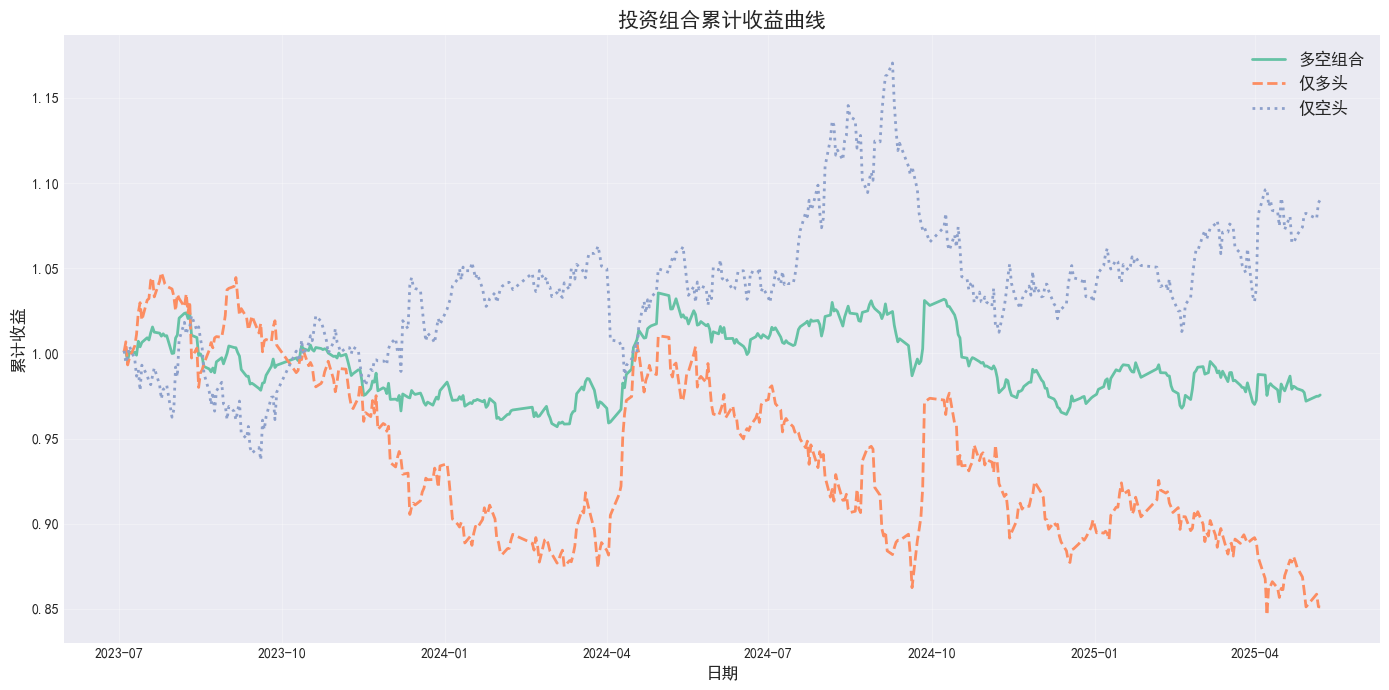

In [30]:
# 绘制净值曲线
plt.figure(figsize=(14, 7))
plt.plot(portfolio_returns['date'], portfolio_returns['cumulative_return'], label='多空组合', linewidth=2)
plt.plot(portfolio_returns['date'], portfolio_returns['long_cumulative'], label='仅多头', linewidth=2, linestyle='--')
plt.plot(portfolio_returns['date'], portfolio_returns['short_cumulative'], label='仅空头', linewidth=2, linestyle=':')
plt.title('投资组合累计收益曲线', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('累计收益', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# 保存图表到文件
plt.savefig(os.path.join(output_dir, plot_filename), dpi=300)
plt.show()

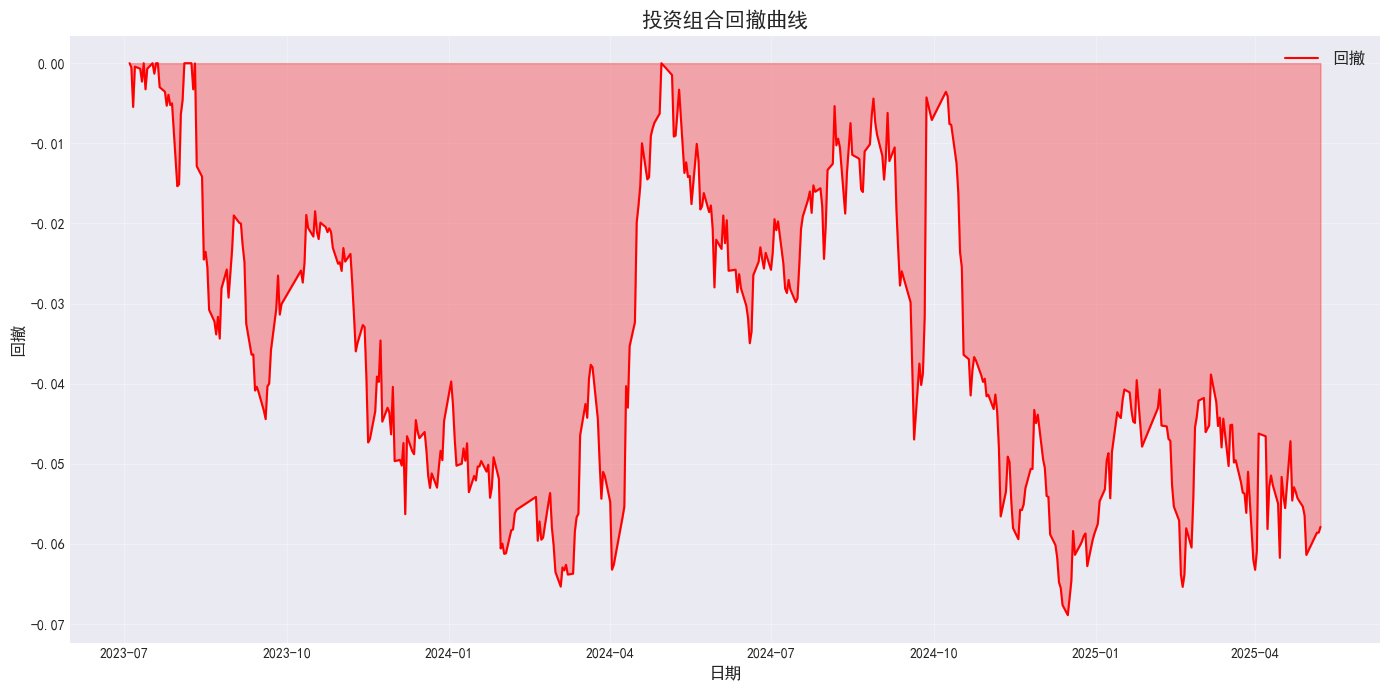

回撤图已保存至: d:\MyTHGNN\analysis_results\portfolio_drawdown_20250804_175914.png


In [31]:
# 计算回撤
def calculate_drawdown(returns):
    """计算回撤序列"""
    cumulative = (1 + returns).cumprod()
    peak = cumulative.expanding().max()
    drawdown = (cumulative - peak) / peak
    return drawdown

# 绘制回撤曲线
plt.figure(figsize=(14, 7))
drawdown = calculate_drawdown(portfolio_returns['return'])
plt.fill_between(portfolio_returns['date'], 0, drawdown, color='red', alpha=0.3)
plt.plot(portfolio_returns['date'], drawdown, color='red', label='回撤')
plt.title('投资组合回撤曲线', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('回撤', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# 保存回撤图
drawdown_filename = f"portfolio_drawdown_{timestamp}.png"
plt.savefig(os.path.join(output_dir, drawdown_filename), dpi=300)
plt.show()

print(f"回撤图已保存至: {os.path.join(output_dir, drawdown_filename)}")

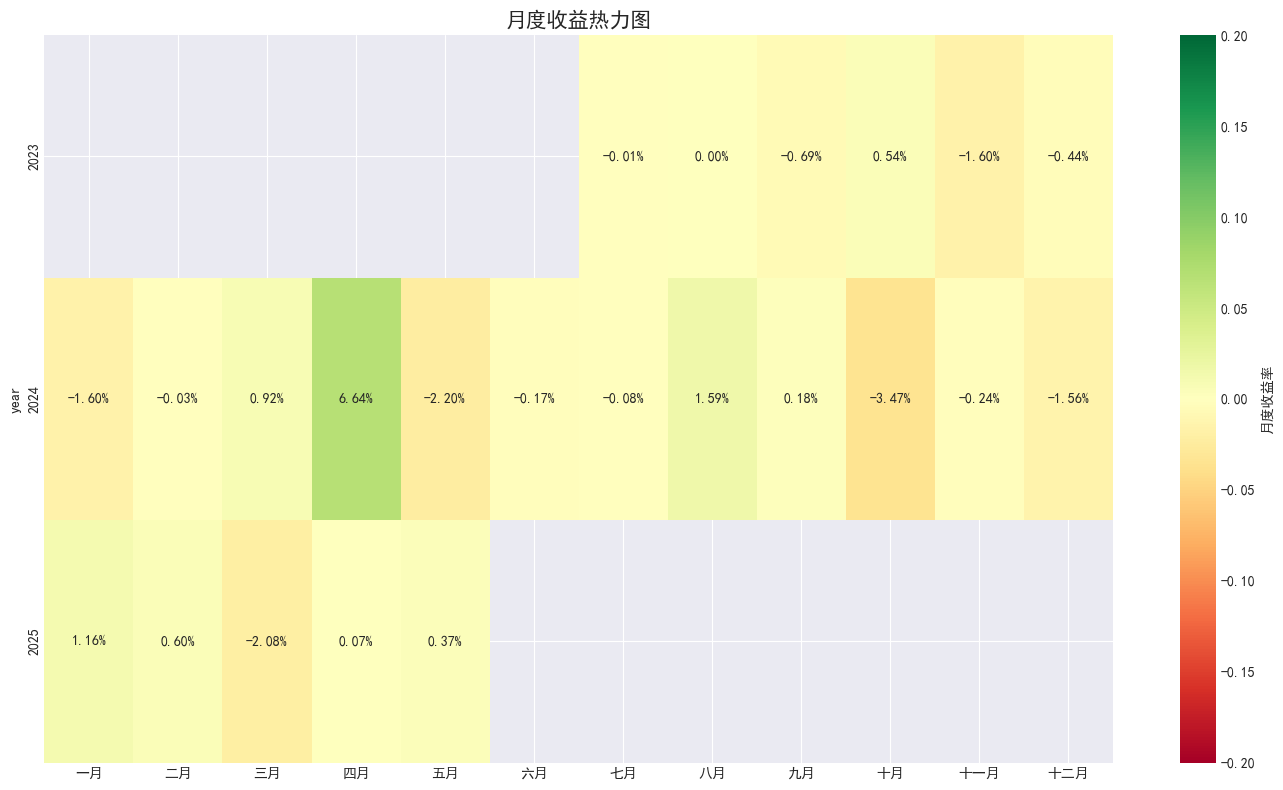

月度收益热力图已保存至: d:\MyTHGNN\analysis_results\monthly_returns_heatmap_20250804_175914.png


In [32]:
# 创建月度收益热力图
# 提取年月信息
portfolio_returns['year'] = portfolio_returns['date'].dt.year
portfolio_returns['month'] = portfolio_returns['date'].dt.month

# 计算月度收益
monthly_returns = portfolio_returns.groupby(['year', 'month'])['return'].apply(lambda x: (1 + x).prod() - 1).reset_index()
monthly_returns_pivot = monthly_returns.pivot(index='year', columns='month', values='return')

# 月份名称
month_names = ['一月', '二月', '三月', '四月', '五月', '六月', 
               '七月', '八月', '九月', '十月', '十一月', '十二月']
monthly_returns_pivot.columns = [month_names[int(m)-1] for m in monthly_returns_pivot.columns]

# 绘制热力图
plt.figure(figsize=(14, 8))
sns.heatmap(monthly_returns_pivot, annot=True, cmap='RdYlGn', fmt='.2%', 
            center=0, vmin=-0.2, vmax=0.2, cbar_kws={'label': '月度收益率'})
plt.title('月度收益热力图', fontsize=15)
plt.tight_layout()

# 保存热力图
heatmap_filename = f"monthly_returns_heatmap_{timestamp}.png"
plt.savefig(os.path.join(output_dir, heatmap_filename), dpi=300)
plt.show()

print(f"月度收益热力图已保存至: {os.path.join(output_dir, heatmap_filename)}")

## 7. 保存分析结果

将分析结果保存到文件，包括:
1. 性能指标
2. 持仓记录
3. 收益率数据

In [33]:
# 保存性能指标
metrics_df.to_csv(os.path.join(output_dir, metrics_filename), index=False, encoding='utf-8-sig')
print(f"性能指标已保存至: {os.path.join(output_dir, metrics_filename)}")

# 保存持仓信息
# 将列表转换为字符串以便保存
positions['long_positions_str'] = positions['long_positions'].apply(lambda x: ', '.join(x))
positions['short_positions_str'] = positions['short_positions'].apply(lambda x: ', '.join(x))
positions_to_save = positions[['date', 'long_positions_str', 'short_positions_str']]
positions_to_save.to_csv(os.path.join(output_dir, positions_filename), index=False, encoding='utf-8-sig')
print(f"持仓信息已保存至: {os.path.join(output_dir, positions_filename)}")

# 保存每日收益率数据
returns_filename = f"daily_returns_{timestamp}.csv"
daily_returns = portfolio_returns[['date', 'return', 'long_return', 'short_return', 'cumulative_return', 
                                 'long_cumulative', 'short_cumulative']]
daily_returns.to_csv(os.path.join(output_dir, returns_filename), index=False, encoding='utf-8-sig')
print(f"每日收益率数据已保存至: {os.path.join(output_dir, returns_filename)}")

# 显示所有保存的文件
saved_files = [
    os.path.join(output_dir, plot_filename),
    os.path.join(output_dir, drawdown_filename),
    os.path.join(output_dir, heatmap_filename),
    os.path.join(output_dir, metrics_filename),
    os.path.join(output_dir, positions_filename),
    os.path.join(output_dir, returns_filename)
]

print("\n所有分析结果文件:")
for f in saved_files:
    print(f"- {f}")

性能指标已保存至: d:\MyTHGNN\analysis_results\performance_metrics_20250804_175914.csv
持仓信息已保存至: d:\MyTHGNN\analysis_results\positions_20250804_175914.csv
每日收益率数据已保存至: d:\MyTHGNN\analysis_results\daily_returns_20250804_175914.csv

所有分析结果文件:
- d:\MyTHGNN\analysis_results\portfolio_cumulative_return_20250804_175914.png
- d:\MyTHGNN\analysis_results\portfolio_drawdown_20250804_175914.png
- d:\MyTHGNN\analysis_results\monthly_returns_heatmap_20250804_175914.png
- d:\MyTHGNN\analysis_results\performance_metrics_20250804_175914.csv
- d:\MyTHGNN\analysis_results\positions_20250804_175914.csv
- d:\MyTHGNN\analysis_results\daily_returns_20250804_175914.csv


## 8. 总结与结论

本分析执行了基于预测分数的多空组合策略，并计算了各项性能指标。主要结果包括:

1. 投资组合的年化收益率和风险指标
2. 多头和空头策略的相对贡献
3. 回撤情况和月度表现分析

所有分析结果都已保存在 `analysis_results` 目录中，并使用时间戳进行了标记，便于追踪不同版本的分析结果。